In [1]:
import sys
if "google.colab" in sys.modules:
  !pip install mim_solvers

In [2]:
import pinocchio as pin
import crocoddyl
import mim_solvers
import numpy
print("✅ Environment ready")

✅ Environment ready


Let us consider the Optimal Control Problem (OCP)
\begin{align}
    \min_{\underline{x}, \underline{u}}~ & \sum_{k=0}^{T-1}~ \ell_k(x_k,u_k) + \ell_T(x_T) \\
    &\text{s.t.}~\begin{cases}
                x_0 &= \hat{x}\nonumber \\
                x_{k+1} &= f_k(x_k, u_k) \nonumber \\
                c_k\left(x_k,u_k\right) &\leq 0 \nonumber \\
                c_T\left(x_T\right) &\leq 0 \nonumber
                \end{cases}
\end{align}
where

* $\underline{x}=\{x_0, ..., x_T\}$ is the state trajectory
* $\underline{x}=\{u_0, ..., u_{T-1}\}$ is the control trajectory
* $\ell_k$ is the running cost
* $\ell_T$ is the terminal cost
* $f_k$ is the dynamics constraint
* $c_k$ is the running constraint
* $c_T$ is the terminal constraint

In this tutorial, we'll see how to make robots move by solving this OCP !

iter    merit      cost     ||gaps||   ||Constraint||   ||(dx,du)||    step     KKT criteria   QP iters 
   0  0.000e+00  1.540e+00  2.091e+01    0.000e+00      3.432e+00      1.000    1.461e-01      25  
   1  2.106e+02  5.388e-01  9.616e+00    0.000e+00      1.234e+00      1.000    1.123e-01      25  
   2  9.670e+01  1.003e-01  1.272e+00    0.000e+00      1.859e-01      1.000    2.014e-02      25  
   3  1.282e+01  9.252e-02  2.412e-03    0.000e+00         ----        ----     5.377e-05       -----  


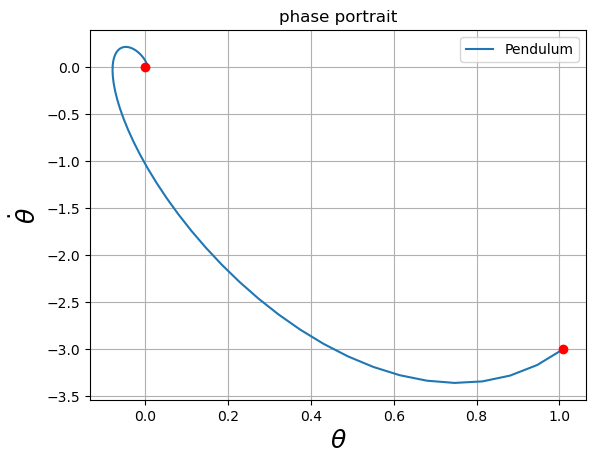

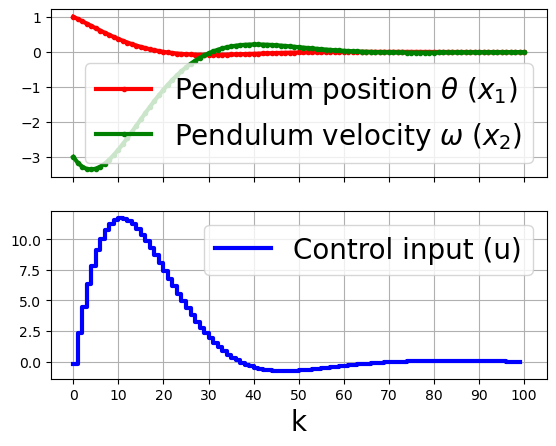

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import crocoddyl
import mim_solvers

# from IPython.display import HTML
# from pendulum_utils import animatePendulum

class DiffActionModelPendulum(crocoddyl.DifferentialActionModelAbstract):
    '''
    This class defines a custom Differential Action Model for the simple pendulum
    It defines the continuous-time
        - dynamics
        - cost
        - constraint
    '''
    def __init__(self, isTerminal=False, hasConstraints=False, dt=0.1):
        self.dt = dt
        self.nq = 1
        self.nv = 1
        self.ndx = 2
        self.nx = self.nq + self.nv
        nu = 1
        nr = 4
        if(hasConstraints and not isTerminal):
            ng = 1
            nh = 0
        else:
            ng = 0
            nh = 0

        # Cost function parameters
        if(isTerminal):
            self.costWeights = [
                1,    # sin(th)
                1,    # 1-cos(th)
                1e-2, # thdot
                1e-3, # f
            ]
        else:
            self.costWeights = [
                1,    # sin(th)
                1,    # 1-cos(th)
                1e-2, # thdot
                1e-3, # f
            ]

        # create action model
        state = crocoddyl.StateVector(self.nx)
        crocoddyl.DifferentialActionModelAbstract.__init__(self, state, nu, nr, ng, nh)
        self.unone = np.zeros(self.nu)

        if hasConstraints and not isTerminal:
            u_lim = 5.
            self.g_lb = np.array([- u_lim])
            self.g_ub = np.array([u_lim])

        self.g = 9.81
        self.L = 1

        self.isTerminal = isTerminal
        self.hasConstraints = hasConstraints

    def _running_cost(self, x, u):


        cost = self.x_weights[0] * (1 - np.cos(x[0])) # cos(th)
        cost += self.x_weights[1] * (np.sin(x[0]))    # sin(th)
        cost += self.x_weights[2] * x[1] ** 2         # thdot
        cost += self.u_weight * u[0] ** 2             # u
        return 0.5 * cost

    def _terminal_cost(self, x):
        cost = self.x_weights[0] * (1 - np.cos(x[0])) # cos(th)
        cost += self.x_weights[1] * (np.sin(x[0]))    # sin(th)
        cost + self.x_weights[2] * x[1] ** 2          # thdot
        return 0.5 * cost

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone

        s, c = np.sin(x[0]), np.cos(x[0])
        if self.isTerminal:
            # Computing the cost residual and value
            data.r[:] = np.array([s, 1 - c, x[1], u[0]]).T
            data.cost = 0.5 * sum(self.costWeights * (np.asarray(data.r) ** 2)).item()
            data.xout = np.zeros(self.state.nx)
        else:
            # Computing the cost residual and value
            data.r = np.array([s, 1 - c, x[1], u[0]]).T
            data.cost = 0.5 * sum(self.costWeights * (np.asarray(data.r) ** 2)).item()
            data.xout = - self.g * np.sin(x[0]) / self.L + u

        if self.hasConstraints and not self.isTerminal:
            data.g[0] = u[0]

    def calcDiff(self, data, x, u=None):
        w = self.costWeights
        s, c = np.sin(x[0]), np.cos(x[0])
        data.Lx[0] = s * ((w[0] - w[1]) * c + w[1])
        data.Lx[1] = w[2] * x[1]
        data.Lxx[0, 0] = w[0] * (c**2 - s**2) + w[1] * (s**2 - c**2 + c)
        data.Lxx[1, 1] = w[2]

        if not self.isTerminal:
            data.Lu[0] = w[3] * u[0]
            data.Luu[0, 0] = w[3]

            data.Fx[0] = - self.g * np.cos(x[0]) / self.L
            data.Fx[1] = 0.
            data.Fu[0] = 1.

        data.Lxu = np.zeros([2, 1])

        if self.isTerminal:
            data.Lx   = self.dt * data.Lx
            data.Lxx =  self.dt * data.Lxx

        if self.hasConstraints and not self.isTerminal:
            data.Gx = np.zeros((self.ng, self.nx))
            data.Gu[0] = 1.


if __name__ == "__main__":

    nx = 2
    nu = 1
    x0 = np.zeros(nx)
    x0[0] = 1+ 0.01
    x0[1] = -3

    # Create the running models
    dt = 2e-2
    T = 100
    running_DAM = DiffActionModelPendulum(isTerminal=False, hasConstraints=False)
    running_model = crocoddyl.IntegratedActionModelEuler(running_DAM, dt)

    running_DAM_terminal = DiffActionModelPendulum(isTerminal=True, hasConstraints=False)
    running_model_terminal = crocoddyl.IntegratedActionModelEuler(running_DAM_terminal, dt)

    # Create the shooting problem
    problem = crocoddyl.ShootingProblem(x0, [running_model] * T, running_model_terminal)


    # # # # # # # # # # # # #
    ###     SOLVE OCP     ###
    # # # # # # # # # # # # #

    # Define warm start
    xs = [x0] * (T + 1)
    us = [np.ones(1)] * T

    # Define solver
    # solver = mim_solvers.SolverCSQP(problem)
    # solver = mim_solvers.SolverSQP(problem)
    solver = mim_solvers.SolverCSQP(problem)
    # solver = crocoddyl.SolverFDDP(problem)
    # solver = crocoddyl.SolverDDP(problem)
    solver.termination_tolerance = 1e-4
    solver.with_callbacks = True
    solver.eps_abs = 1e-10
    solver.eps_rel = 0.
    solver.use_filter_line_search = False
    # solver.extra_iteration_for_last_kkt = True
    # Solve
    max_iter = 200
    solver.setCallbacks([mim_solvers.CallbackVerbose()])
    # solver.setCallbacks([crocoddyl.CallbackVerbose()])
    solver.solve(xs, us, max_iter, False)

    x_traj = np.array(solver.xs)
    u_traj = np.array(solver.us)

    # Create animation
    # anim = animatePendulum(solver.xs)

    import matplotlib.pyplot as plt

    time_lin = np.linspace(0, dt * (T + 1), T+1)

    # fig, axs = plt.subplots(nx)
    # for i in range(nx):
    #     axs[i].plot(time_lin, x_traj[:, i])
    #     axs[i].grid()
    # fig.suptitle("State trajectory")

    # plt.figure()
    # plt.plot(time_lin[:-1], u_traj[:])
    # plt.title("Control trajectory")
    # plt.grid()

    plt.figure()
    plt.plot(x_traj[:, 0],  x_traj[:, 1], label='Pendulum')
    plt.plot(x_traj[0,0], x_traj[0,1], 'ro')
    plt.plot(0, 0, 'ro')
    # plt.plot(3 * np.pi, 0, 'ro')

    plt.legend()
    plt.title("phase portrait")
    plt.xlabel("$\\theta$", fontsize=18)
    plt.ylabel("$\\dot\\theta$", fontsize=18)
    plt.grid()

    # fancy plot with discretization
    fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')
    time_discrete = range(T+1)
    ax1.plot(time_discrete,  x_traj[:, 0], linewidth=3, color='r', marker='.', label='Pendulum position $\\theta$ ($x_1$)')
    ax1.plot(time_discrete,  x_traj[:, 1], linewidth=3, color='g', marker='.', label='Pendulum velocity $\\omega$ ($x_2$)')
    ax1.grid()
    ax1.legend(fontsize=20)

    ax2.step(time_discrete[:-1],  u_traj, where='post', linewidth=3, linestyle=None, color='b', label='Control input (u)')
    ax2.set_xlabel("k", fontsize=20)
    # plt.ylabel("$\\dot\\theta$", fontsize=18)
    ax2.grid()
    ax2.legend(fontsize=20)
    ax2.locator_params(axis='x', nbins=20)
    # utils.plot_pendulum_value(X, Y, cmap, z_pred, "Unscaled learned value", folder, None, solver_name)

    plt.show()